In [2]:
import os
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Download the dataset
print("Downloading dataset...")
path = kagglehub.dataset_download("jagdishchakole1/mango-data")
print("Dataset downloaded successfully!")
print("Path to dataset files:", path)

# Define data directories
train_dir = os.path.join(path, "Mango_leaf_disease1/train")
val_dir = os.path.join(path, "Mango_leaf_disease1/val")
test_dir = os.path.join(path, "Mango_leaf_disease1/test")

Dataset downloaded successfully!
Path to dataset files: /kaggle/input/mango-data


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling only for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get the number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print("Class mapping:", train_generator.class_indices)

Found 2800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Number of classes: 8
Class mapping: {'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


In [4]:
print("Loading InceptionV3 model...")
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

Loading InceptionV3 model...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
print("Compiling the model...")
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train the model
print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping, reduce_lr]
)
print("Training completed!")

Compiling the model...
Starting training...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 112s 995ms/step - accuracy: 0.5409 - loss: 1.3471 - val_accuracy: 0.9225 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.8125 - loss: 0.4575 - learning_rate: 1.0000e-04
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 618ms/step - accuracy: 0.9108 - loss: 0.3299 - val_accuracy: 0.9350 - val_loss: 0.2129 - learning_rate: 1.0000e-04
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 217us/step - accuracy: 0.8750 - loss: 0.3470 - learning_rate: 1.0000e-04
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 612ms/step - accuracy: 0.9443 - loss: 0.2133 - val_accuracy: 0.9475 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step - accuracy: 0.9688 - loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 7/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 615ms/step - accuracy: 0.9463 - loss: 0.1763 - val_accuracy: 0.9575 - val_loss: 0.1349 - learning_rate: 1.0000e-04
Epoch 8/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step - accuracy: 0.9688 - loss: 0.2104 - learning_rate: 1.0000e-04
Epoch 9/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 58s 615ms/step - accuracy: 0.9532 - loss: 0.1469 - val_accuracy: 0.9550 - val_loss: 0.1391 - learning_rate: 1.0000e-04
Epoch 10/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s

In [6]:
print("Evaluating model on test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

model.save('mango_disease_inception_model.h5')
print("Model saved as mango_disease_inception_model.h5")


Evaluating model on test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.9849 - loss: 0.0585
Test accuracy: 0.9750
Model saved as mango_disease_inception_model.h5


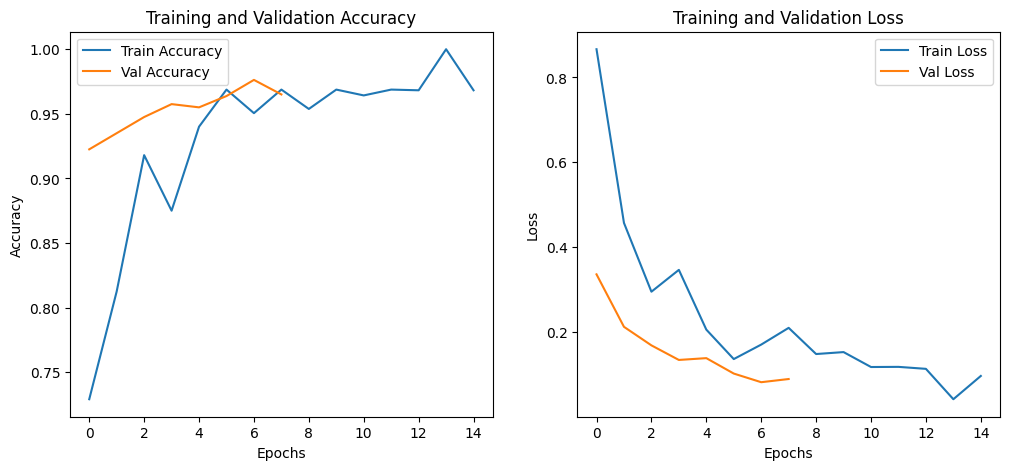

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Call the function to plot graphs
plot_training_history(history)
